# Midterm project

## Credit Card Fraud

#### Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

#### Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb

import optuna
import optuna.integration 
import XGBoostPruningCallback, LightGBMPruningCallback

from imblearn.over_sampling import SMOTE

from collections import Counter

ModuleNotFoundError: No module named 'kagglehub'

In [4]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

100%|██████████████████████████████████████| 66.0M/66.0M [00:13<00:00, 5.32MB/s]

Extracting files...


Path to dataset files: /Users/sopijane/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [5]:
csv_path = os.path.join(path, "creditcard.csv")
csv_path

'/Users/sopijane/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3/creditcard.csv'

In [6]:
df = pd.read_csv(csv_path)

In [9]:
df.columns = df.columns.str.lower()

In [10]:
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.isna().sum().max()

np.int64(0)

No missing values from this dataset

In [9]:
df.describe()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
df.duplicated().sum()

np.int64(1081)

There are 1081 duplicated records. We will remove the duplicates from the dataset

In [11]:
df = df.drop_duplicates()

#### Target variable analysis

In [12]:
df['class'].value_counts(normalize=True)*100

class
0    99.83329
1     0.16671
Name: proportion, dtype: float64

We can see a highly class imbalance from the dataset. Class 1, fraudulent transactions are only 0.17% compared to class 0. We will need to handle this later on using over-sampling method called SMOTE.

Text(0.5, 1.0, 'Transaction Time by Class')

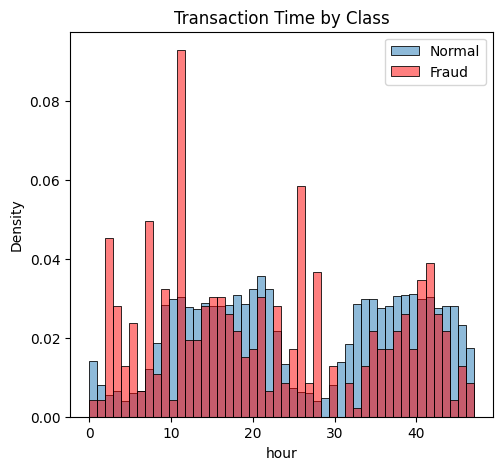

In [13]:
df['hour'] = df['time'] // 3600
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data=df[df['class']==0], x='hour', bins=48, stat='density', alpha=0.5, label='Normal')
sns.histplot(data=df[df['class']==1], x='hour', bins=48, stat='density', alpha=0.5, color='red', label='Fraud')
plt.legend()
plt.title('Transaction Time by Class')

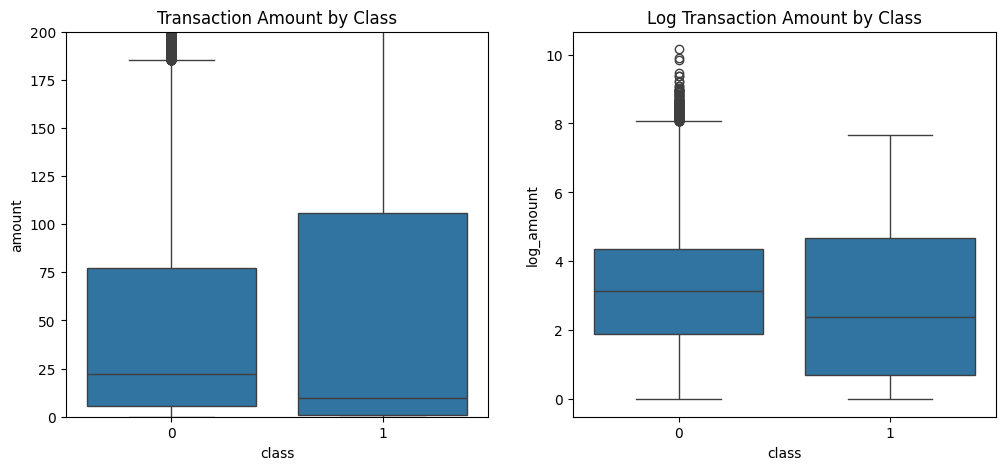

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=df, x='class', y='amount')
plt.ylim(0, 200) # Zoom in to see the IQR better, as fraud amounts can be high
plt.title('Transaction Amount by Class')

plt.subplot(1,2,2)
# Log transform to better visualize the spread
df['log_amount'] = np.log1p(df['amount'])
sns.boxplot(data=df, x='class', y='log_amount')
plt.title('Log Transaction Amount by Class')
plt.show()

In [15]:
print(df.groupby('class')['amount'].describe())

          count        mean         std  min   25%    50%     75%       max
class                                                                      
0      283253.0   88.413575  250.379023  0.0  5.67  22.00   77.46  25691.16
1         473.0  123.871860  260.211041  0.0  1.00   9.82  105.89   2125.87


#### Splitting the data

In [16]:
X_full_train, X_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df['class'])
X_train, X_val = train_test_split(X_full_train, test_size=0.25, random_state=1,
    stratify=X_full_train["class"]
)

In [17]:
print("Train:", Counter(X_train["class"]))
print("Val:  ", Counter(X_val["class"]))
print("Test: ", Counter(X_test["class"]))

Train: Counter({0: 169952, 1: 283})
Val:   Counter({0: 56650, 1: 95})
Test:  Counter({0: 56651, 1: 95})


In [20]:
y_train = X_train['class'].values
y_val = X_val['class'].values
y_test = X_test['class'].values

In [21]:
del X_train['class']
del X_val['class']
del X_test['class']

#### Scale Time and Amount

In [22]:
scaler = StandardScaler()

In [23]:
cols_scale = ['time', 'amount']

X_train[cols_scale] = scaler.fit_transform(X_train[cols_scale])
X_val[cols_scale]   = scaler.transform(X_val[cols_scale])
X_test[cols_scale]  = scaler.transform(X_test[cols_scale])

We don't need to scale the rest of the features because they are already PCA-scaled

#### Handling imbalance using SMOTE

In [24]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [25]:
print("Before resampling:", Counter(y_train))
print("After resampling: ", Counter(y_train_sm))

Before resampling: Counter({np.int64(0): 169952, np.int64(1): 283})
After resampling:  Counter({np.int64(0): 169952, np.int64(1): 169952})


Now, the ratio between class 1 and 0 is balanced. This will let the model to give both classes the same weight during training.

#### Training the model

In [26]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
y_pred_rf = rf.predict_proba(X_val)[:,1]

In [28]:
auc_rf = roc_auc_score(y_val, y_pred_rf)
prec, rec, thresh = precision_recall_curve(y_val, y_pred_rf)
pr_auc_rf = auc(rec, prec)

In [29]:
print("AUC_ROC: %.3f" % auc_rf)
print("AUPRC: %.3f" % pr_auc_rf)

AUC_ROC: 0.957
AUPRC: 0.890


In [30]:
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)

best_index = np.argmax(f1)
best_thresh = thresh[best_index]

print("Best threshold (via PR curve):", best_thresh)
print("Best F1:", f1[best_index])

Best threshold (via PR curve): 0.46
Best F1: 0.9120879115888781


#### Selecting threshold

In [41]:
target_recall = 0.90   # example

best_thresh = 0
best_diff = 999

thresholds = np.linspace(0, 1, 200)

for t in thresholds:
    preds = (y_pred_rf >= t).astype(int)
    recall = ( (preds & y_val).sum() / y_val.sum() )
    diff = abs(recall - target_recall)
    if diff < best_diff:
        best_diff = diff
        best_thresh = t

print("Threshold for ~90% recall:", best_thresh)

Threshold for ~90% recall: 0.010050251256281407


In [46]:
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)

best_index = np.argmax(f1)
best_thresh = thresh[best_index]

print("Best threshold (via PR curve):", best_thresh)
print("Best F1:", f1[best_index])

Best threshold (via PR curve): 0.38
Best F1: 0.9032258059518441


In [42]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

In [38]:
# Integrate MLFLow with Random forest
def run_experiment(n_estimators=200, max_depth=None, min_samples_split=2):
    with mlflow.start_run():

        # log parameters
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_deph", max_depth)
        mlflow.log_param("min_samples_split", min_samples_split)

        # train model
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train_sm, y_train_sm)

        # prediction
        y_pred = model.predict_proba(X_val)[:, 1]

        # metrics
        auc_roc = roc_auc_score(y_val, y_pred)
        prec, rec, thresh = precision_recall_curve(y_val, y_pred)
        pr_auc = auc(rec, prec)

        # log metrics
        mlflow.log_metric("AUC_ROC", auc_roc)
        mlflow.log_metric("AUPRC", pr_auc)

        # save model
        input_example = X_val.iloc[:1]
        signature = infer_signature(X_val, model.predict_proba(X_val)[:, 1])

        mlflow.sklearn.log_model(
            sk_model=model,
            name="random_forest_model",
            input_example=input_example,
            signature=signature
        )

        print(f'Run logged -> AUC_ROC= {auc_roc:.3f}, AUPRC={pr_auc:.3f}')

In [39]:
run_experiment()

Run logged -> AUC_ROC= 0.990, AUPRC=0.905


In [ ]:
def run_experiment(
    model_class,
    model_params: dict,
    X_train, y_train,
    X_val, y_val,
    model_name='model'
):
    """
    Train a model with MLflow logging.

    Parameters
    ----------
    model_class : class
        e.g. RandomForestClassifier, xgb.XGBClassifier, lgb.LGBMClassifier
    model_params : dict
        Hyperparameters for the model
    X_train, y_train : training data
    X_val, y_val : validation data
    model_name : MLflow registered model name
    """

    with mlflow.start_run():

        # log model parameters
        #for param, value in model_params.items():
        #    mlflow.log_param(param, value)
        mlflow.log_params(model_params)

        # create model
        model = model_class(**model_params)

       # ===============================
        # EARLY STOPPING HANDLING
        # ===============================
        if model_class.__name__ == "XGBClassifier":
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric="aucpr",
                early_stopping_rounds=100,
                verbose=False
            )

        elif model_class.__name__ == "LGBMClassifier":
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric="average_precision",  # PR-AUC equivalent
                early_stopping_rounds=100,
                verbose=False
            )

        else:
            # default behavior (RandomForest, Logistic, etc.)
            model.fit(X_train, y_train)

        # predict probabilities
        y_pred = model.predict_proba(X_val)[:, 1]

        # compute metrics
        auc_roc = roc_auc_score(y_val, y_pred)
        prec, rec, thresh = precision_recall_curve(y_val, y_pred)
        pr_auc = auc(rec, prec)

        mlflow.log_metric("AUC_ROC", auc_roc)
        mlflow.log_metric("AUPRC", pr_auc)

        # infer model signature
        signature = infer_signature(X_train, model.predict(X_train))

        mlflow.sklearn.log_model(
            sk_model=model,
            name=model_name,
            input_example=X_train[:5],
            signature=signature
        )
        
        print(f"[{model_name}] AUC_ROC={auc_roc:.3f}, AUPRC={pr_auc:.3f}")

    return model, auc_roc, pr_auc

In [44]:
model_params_rf = {
    'n_estimators': 200,
    'max_depth': None,
    'min_samples_split': 2,
    'random_state': 42,
    'n_jobs': -1
}

run_experiment(
    model_class=RandomForestClassifier,
    model_params=model_params_rf,
    X_train=X_train_sm,
    y_train=y_train_sm,
    X_val=X_val,
    y_val=y_val,
    model_name='rf_model'
)

[rf_model] AUC_ROC=0.990, AUPRC=0.905


(RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42),
 0.9903744135271983,
 0.9048085327724034)

In [ ]:
def make_objective(model_class, X_train, y_train, X_val, y_val):
    def objective(trial):
        """
        Optuna objective function that samples hyperparameters
        and evaluates them using run_experiment().
        """
        # --- Define search space depending on model ---
        if model_class.__name__ == "RandomForestClassifier":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 100, 600),
                "max_depth": trial.suggest_int("max_depth", 3, 20),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
                "random_state": 42,
                "n_jobs": -1
            }

        elif model_class.__name__ == "XGBClassifier":
            params = {
                "n_estimators": 1000,
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.0, log=True)
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.0, log=True),
                "eval_metric": "aucpr",
                "tree_method": "hist",
                "n_jobs": -1
            }

        elif model_class.__name__ == "LGBMClassifier":
            params = {
                "n_estimators": 2000,  # intentionally large
                "num_leaves": trial.suggest_int("num_leaves", 16, 128),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
                "max_depth": trial.suggest_int("max_depth", -1, 12),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10.0, log=True),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.0, log=True),
                "n_jobs": -1
            }

        else:
            raise ValueError("Unsupported model_class for this objective function.")

        # --- Run your MLflow experiment ---
        _, auc_roc, pr_auc = run_experiment(
            model_class=model_class,
            model_params=params,
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            model_name=f"{model_class.__name__}_optuna"
        )

        return pr_auc  # Optuna maximizes this metric

    return objective


In [50]:
def optimize_model(model_class, X_train, y_train, X_val, y_val, n_trials=30):
    study = optuna.create_study(
        direction='maximize'
    )
    objective = make_objective(model_class, X_train, y_train, X_val, y_val)

    study.optimize(objective, n_trials=n_trials)

    print("Best AUC-ROC:", study.best_value)
    print("Best parameters:", study.best_params)

    return study.best_params

In [52]:
best_params = optimize_model(
    model_class=RandomForestClassifier,
    X_train=X_train_sm,
    y_train=y_train_sm,
    X_val=X_val,
    y_val=y_val,
    n_trials=30
)

[I 2025-11-17 01:44:32,372] A new study created in memory with name: no-name-9136eef0-3b44-41e0-9392-bb8bae6dc677
[I 2025-11-17 01:46:10,001] Trial 0 finished with value: 0.7568148182345034 and parameters: {'n_estimators': 327, 'max_depth': 5, 'min_samples_split': 8}. Best is trial 0 with value: 0.7568148182345034.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.757


[I 2025-11-17 01:49:18,568] Trial 1 finished with value: 0.8867097567093855 and parameters: {'n_estimators': 290, 'max_depth': 13, 'min_samples_split': 5}. Best is trial 1 with value: 0.8867097567093855.


[RandomForestClassifier_optuna] AUC_ROC=0.994, AUPRC=0.887


[I 2025-11-17 01:52:29,198] Trial 2 finished with value: 0.8104025644187517 and parameters: {'n_estimators': 425, 'max_depth': 7, 'min_samples_split': 16}. Best is trial 1 with value: 0.8867097567093855.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.810


[I 2025-11-17 01:58:04,460] Trial 3 finished with value: 0.8907371609387164 and parameters: {'n_estimators': 446, 'max_depth': 13, 'min_samples_split': 8}. Best is trial 3 with value: 0.8907371609387164.


[RandomForestClassifier_optuna] AUC_ROC=0.995, AUPRC=0.891


[I 2025-11-17 02:03:36,270] Trial 4 finished with value: 0.8897711881925794 and parameters: {'n_estimators': 429, 'max_depth': 13, 'min_samples_split': 13}. Best is trial 3 with value: 0.8907371609387164.


[RandomForestClassifier_optuna] AUC_ROC=0.994, AUPRC=0.890


[I 2025-11-17 02:10:38,883] Trial 5 finished with value: 0.899207291492909 and parameters: {'n_estimators': 516, 'max_depth': 20, 'min_samples_split': 9}. Best is trial 5 with value: 0.899207291492909.


[RandomForestClassifier_optuna] AUC_ROC=0.997, AUPRC=0.899


[I 2025-11-17 02:16:53,592] Trial 6 finished with value: 0.8983352982546855 and parameters: {'n_estimators': 509, 'max_depth': 18, 'min_samples_split': 9}. Best is trial 5 with value: 0.899207291492909.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.898


[I 2025-11-17 02:17:59,823] Trial 7 finished with value: 0.827443850828041 and parameters: {'n_estimators': 128, 'max_depth': 8, 'min_samples_split': 9}. Best is trial 5 with value: 0.899207291492909.


[RandomForestClassifier_optuna] AUC_ROC=0.997, AUPRC=0.827


[I 2025-11-17 02:19:39,591] Trial 8 finished with value: 0.7267683473903972 and parameters: {'n_estimators': 519, 'max_depth': 3, 'min_samples_split': 5}. Best is trial 5 with value: 0.899207291492909.


[RandomForestClassifier_optuna] AUC_ROC=0.995, AUPRC=0.727


[I 2025-11-17 02:20:34,979] Trial 9 finished with value: 0.8385797660734302 and parameters: {'n_estimators': 102, 'max_depth': 8, 'min_samples_split': 4}. Best is trial 5 with value: 0.899207291492909.


[RandomForestClassifier_optuna] AUC_ROC=0.997, AUPRC=0.839


[I 2025-11-17 02:28:08,377] Trial 10 finished with value: 0.8998158994420985 and parameters: {'n_estimators': 570, 'max_depth': 20, 'min_samples_split': 20}. Best is trial 10 with value: 0.8998158994420985.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.900


[I 2025-11-17 02:36:08,648] Trial 11 finished with value: 0.9000266214554073 and parameters: {'n_estimators': 599, 'max_depth': 20, 'min_samples_split': 20}. Best is trial 11 with value: 0.9000266214554073.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.900


[I 2025-11-17 02:44:34,213] Trial 12 finished with value: 0.8958295929303145 and parameters: {'n_estimators': 598, 'max_depth': 17, 'min_samples_split': 20}. Best is trial 11 with value: 0.9000266214554073.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.896


[I 2025-11-17 02:52:02,744] Trial 13 finished with value: 0.8943920568694571 and parameters: {'n_estimators': 583, 'max_depth': 16, 'min_samples_split': 20}. Best is trial 11 with value: 0.9000266214554073.


[RandomForestClassifier_optuna] AUC_ROC=0.995, AUPRC=0.894


[I 2025-11-17 02:55:12,506] Trial 14 finished with value: 0.8989894459245434 and parameters: {'n_estimators': 246, 'max_depth': 20, 'min_samples_split': 17}. Best is trial 11 with value: 0.9000266214554073.


[RandomForestClassifier_optuna] AUC_ROC=0.994, AUPRC=0.899


[I 2025-11-17 03:02:20,577] Trial 15 finished with value: 0.8930937929472038 and parameters: {'n_estimators': 557, 'max_depth': 16, 'min_samples_split': 17}. Best is trial 11 with value: 0.9000266214554073.


[RandomForestClassifier_optuna] AUC_ROC=0.994, AUPRC=0.893


[I 2025-11-17 03:09:13,346] Trial 16 finished with value: 0.8959615143750003 and parameters: {'n_estimators': 465, 'max_depth': 19, 'min_samples_split': 14}. Best is trial 11 with value: 0.9000266214554073.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.896


[I 2025-11-17 03:13:22,488] Trial 17 finished with value: 0.8788433640656739 and parameters: {'n_estimators': 377, 'max_depth': 11, 'min_samples_split': 19}. Best is trial 11 with value: 0.9000266214554073.


[RandomForestClassifier_optuna] AUC_ROC=0.995, AUPRC=0.879


[I 2025-11-17 03:20:54,503] Trial 18 finished with value: 0.8960641772111918 and parameters: {'n_estimators': 600, 'max_depth': 15, 'min_samples_split': 14}. Best is trial 11 with value: 0.9000266214554073.


[RandomForestClassifier_optuna] AUC_ROC=0.995, AUPRC=0.896


[I 2025-11-17 03:23:56,527] Trial 19 finished with value: 0.8964231537477751 and parameters: {'n_estimators': 213, 'max_depth': 18, 'min_samples_split': 2}. Best is trial 11 with value: 0.9000266214554073.


[RandomForestClassifier_optuna] AUC_ROC=0.995, AUPRC=0.896


[I 2025-11-17 03:28:00,275] Trial 20 finished with value: 0.8787972999282782 and parameters: {'n_estimators': 379, 'max_depth': 11, 'min_samples_split': 18}. Best is trial 11 with value: 0.9000266214554073.


[RandomForestClassifier_optuna] AUC_ROC=0.995, AUPRC=0.879


[I 2025-11-17 03:35:35,850] Trial 21 finished with value: 0.9001499821201105 and parameters: {'n_estimators': 526, 'max_depth': 20, 'min_samples_split': 11}. Best is trial 21 with value: 0.9001499821201105.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.900


[I 2025-11-17 03:43:23,227] Trial 22 finished with value: 0.8990276291351381 and parameters: {'n_estimators': 547, 'max_depth': 20, 'min_samples_split': 15}. Best is trial 21 with value: 0.9001499821201105.


[RandomForestClassifier_optuna] AUC_ROC=0.995, AUPRC=0.899


[I 2025-11-17 03:49:34,563] Trial 23 finished with value: 0.8950249336622227 and parameters: {'n_estimators': 479, 'max_depth': 18, 'min_samples_split': 12}. Best is trial 21 with value: 0.9001499821201105.


[RandomForestClassifier_optuna] AUC_ROC=0.995, AUPRC=0.895


[I 2025-11-17 03:56:20,894] Trial 24 finished with value: 0.8935301466176568 and parameters: {'n_estimators': 550, 'max_depth': 15, 'min_samples_split': 11}. Best is trial 21 with value: 0.9001499821201105.


[RandomForestClassifier_optuna] AUC_ROC=0.994, AUPRC=0.894


[I 2025-11-17 10:50:14,992] Trial 25 finished with value: 0.8971482058651836 and parameters: {'n_estimators': 493, 'max_depth': 19, 'min_samples_split': 18}. Best is trial 21 with value: 0.9001499821201105.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.897


[I 2025-11-17 10:55:59,201] Trial 26 finished with value: 0.8951757565016081 and parameters: {'n_estimators': 545, 'max_depth': 17, 'min_samples_split': 20}. Best is trial 21 with value: 0.9001499821201105.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.895


[I 2025-11-17 11:02:39,578] Trial 27 finished with value: 0.9003469862950141 and parameters: {'n_estimators': 566, 'max_depth': 20, 'min_samples_split': 11}. Best is trial 27 with value: 0.9003469862950141.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.900


[I 2025-11-17 11:06:57,708] Trial 28 finished with value: 0.8912072420178722 and parameters: {'n_estimators': 390, 'max_depth': 15, 'min_samples_split': 11}. Best is trial 27 with value: 0.9003469862950141.


[RandomForestClassifier_optuna] AUC_ROC=0.994, AUPRC=0.891


[I 2025-11-17 11:10:58,118] Trial 29 finished with value: 0.8956563481218991 and parameters: {'n_estimators': 336, 'max_depth': 19, 'min_samples_split': 7}. Best is trial 27 with value: 0.9003469862950141.


[RandomForestClassifier_optuna] AUC_ROC=0.996, AUPRC=0.896
Best AUC-ROC: 0.9003469862950141
Best parameters: {'n_estimators': 566, 'max_depth': 20, 'min_samples_split': 11}


In [56]:
best_params

{'n_estimators': 566, 'max_depth': 20, 'min_samples_split': 11}

In [58]:
final_params = {
    'n_estimators': 566,
    'max_depth': 20,
    'min_samples_split': 11
}

In [62]:
rf = RandomForestClassifier(
    n_estimators=556,
    max_depth=20,
    min_samples_split=11,
    random_state=42
)
rf.fit(X_train_sm, y_train_sm)

,n_estimators,556
,criterion,'gini'
,max_depth,20
,min_samples_split,11
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False
